# Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

In [1]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

#function to plot grid
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42


SEED = 1234
seed(SEED)
np.random.seed(SEED)

df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [2]:
# preparing data by selecting needed colums and removing empty values
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
#df = df.dropna(how='any')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


next we need to convert string data into values/ numbers to be able to use it to train, test and predict

In [3]:
#converting to values
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


0    0.549348
1    0.450652
Name: two_year_recid, dtype: float64

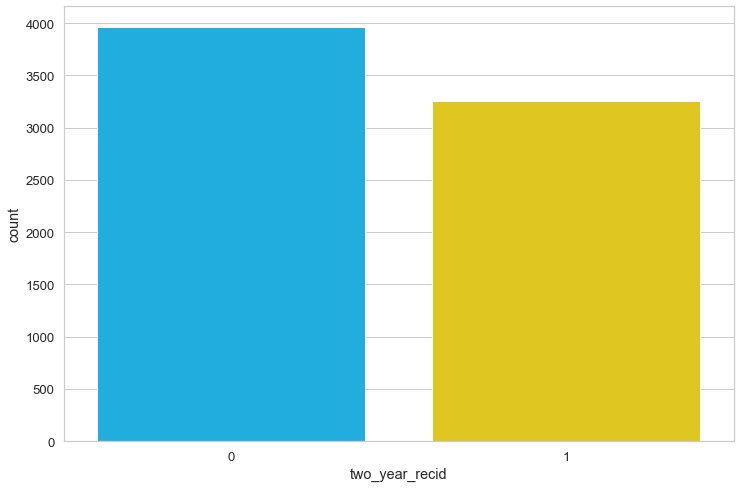

In [4]:
# with our model, we select "df.two_year_recid" column to be our ground truth
#count Plot ground truth and percentage
sns.countplot(df.two_year_recid);
df.two_year_recid.value_counts() / df.shape[0]

About 45 percent have a two year recid from the data and this is a possibility of being jailed for a smaller offense. but this does not take into account any other parameter such as race into consideration. This is just the possibility of been jailed when an offense is committed.


Next step is to divide our dataset. we cannot use the same data trained for testing so we divide the data into train and test set. we will use 0.2 percent of the training dataset as the validation set. We then need to convert them into a tensor(a set of data/ information relating to one person as relating to COMPAS) to be able to train and test with Pytorch

In [5]:
#splitting and converting data to tensor
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5771, 10]) torch.Size([5771])
torch.Size([1443, 10]) torch.Size([1443])


### Building the network
From the shape above, our input data contains 10 columns.
Our network will also have two hidden layers of 5 and 3 nodes respectively

#### First Model

In [6]:
# Defining the model
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [7]:
# ann_viz(net, view=False)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)
# net = net.to(device)
# criterion = criterion.to(device)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1200):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

# Save model
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

epoch 0
Train set - loss: 0.693, accuracy: 0.544
Test  set - loss: 0.684, accuracy: 0.57

epoch 400
Train set - loss: 0.689, accuracy: 0.544
Test  set - loss: 0.685, accuracy: 0.57

epoch 800
Train set - loss: 0.689, accuracy: 0.544
Test  set - loss: 0.685, accuracy: 0.57



D:\conda\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
# Test the model using test set
net = torch.load(MODEL_PATH)
classes = ['No Recid', 'Recid']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

    No Recid       0.57      1.00      0.73       823
       Recid       0.00      0.00      0.00       620

    accuracy                           0.57      1443
   macro avg       0.29      0.50      0.36      1443
weighted avg       0.33      0.57      0.41      1443

Overall Accuracy :  0.5703395703395704


D:\conda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our model produces a higher overall accuracy of 0.91 as compared to the compass model of 0.65 

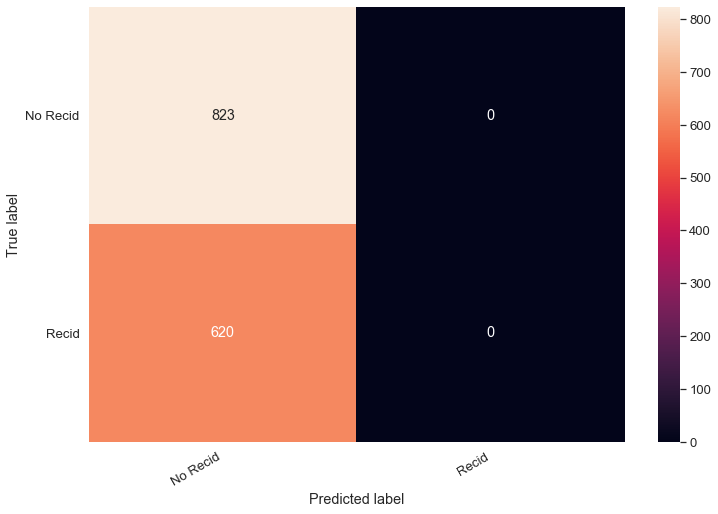

In [9]:
# Plot
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Predicting Recidivism(tendency to reoffend)
Definitions and possible parameters.
We would like to analyse some possible attributes that account for the risk of recidivism. Prior_count, race and decile scores

### Prior Counts

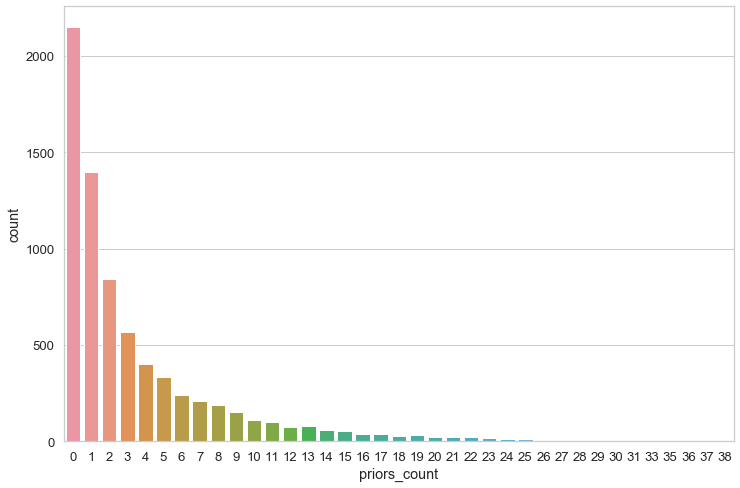

In [10]:
# graph showing prior count to help in prediction
sns.countplot(df.priors_count);


predicting using violent decile scores. Below are graphs by race and the violent decile scores as compared with the decile scores in part one of the project

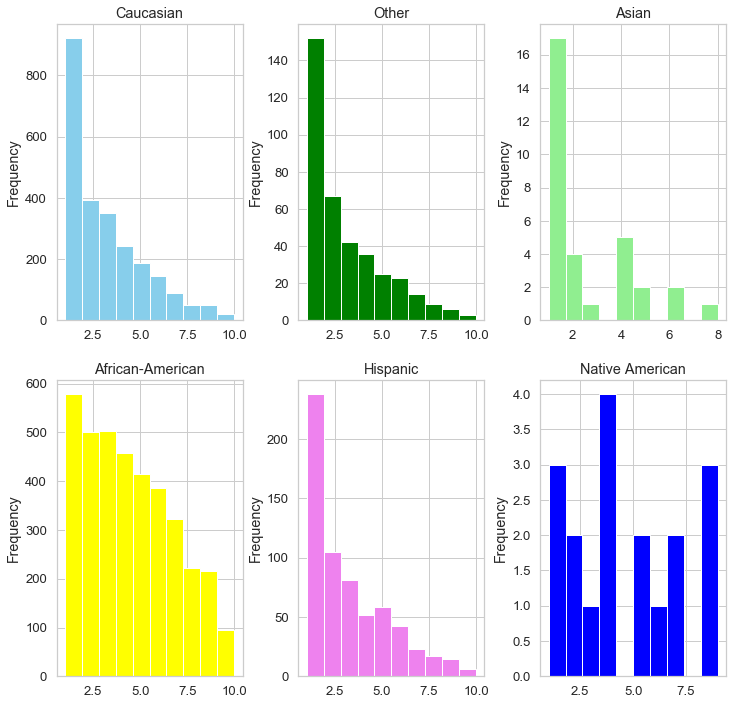

In [11]:
#sns.countplot(df.v_decile_score)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

df['v_decile_score'].loc[df['race'] == 3].plot(ax=axes[0,0], kind='hist', color = "skyblue", title='Caucasian')
df['v_decile_score'].loc[df['race'] == 1].plot(ax=axes[0,1],kind='hist', color = "green", title='Other')
df['v_decile_score'].loc[df['race'] == 6].plot(ax=axes[0,2],kind='hist', color = "lightgreen", title='Asian')
df['v_decile_score'].loc[df['race'] == 2].plot(ax=axes[1,0],kind='hist', color = "yellow", title='African-American')
df['v_decile_score'].loc[df['race'] == 4].plot(ax=axes[1,1],kind='hist', color = "violet", title='Hispanic')
df['v_decile_score'].loc[df['race'] == 5].plot(ax=axes[1,2],kind='hist', color = "blue", title='Native American')

from the charts above, we can see that our training model predict almost same as the original Propublica predictions. Only African-American is slightly different but not large enough to draw a conclusion of fairness.
all charts except african americans shows they are a bit violent as compared to the initial graph using just decile scores. the graph for African-american shows the reduction in violence as compared to using just decile scores as in the first part of the project. The most intersting change here is Native American whose chart id very different on violence basis.

We can say this is a bit fair as the original compass classifier but wwe would like to do some predictions to conclude on fairness. With African American, it didnt predict that all risk ranges ahve a higher rate of recidivism as predicted by compass. In Native Americans, It aso showed a class of people with a higher rate of recidivism.

some sample Predictions follow below.

<!-- Below is a graph showing the race distributionfor the dataset. African-American has the largest data which we can say might be one way of predicting that the largest population committing an offense is more likely to recidiviate.

### Race -->


In [12]:
#sns.countplot(df.race)

<!-- #### Definitions for race
        Other: 1 
        African-American: 2
        Caucasian: 3
        Hispanic: 4
        Native American: 5
        Asian: 6
 -->

In [13]:
def will_recid(sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event):
  t = torch.as_tensor([sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event]) \
      .float()
  output = net(t)
  return output.ge(0.5).item()

# Possible values
print("sex : " + str(df.sex.unique()))
print("race : " + str(df.race.unique()))
print("age_cat : " + str(df.age_cat.unique()))
print("juv_fel_count : " + str(df.juv_fel_count.unique()))
print("juv_misd_count : " + str(df.juv_misd_count.unique()))
print("priors_count : " + str(df.priors_count.unique()))
print("c_charge_degree : " + str(df.c_charge_degree.unique()))
print("is_violent_recid : " + str(df.is_violent_recid.unique()))
print("v_decile_score : " + str(df.v_decile_score.unique()))
print("event : " + str(df.event.unique()))

sex : [1 2]
race : [1 2 3 4 5 6]
age_cat : [1 2 3]
juv_fel_count : [ 0  2  1  8  4  3  9 20  6  5 10]
juv_misd_count : [ 0  1  6 12  2  4  3  8  5 13]
priors_count : [ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
c_charge_degree : [1 2]
is_violent_recid : [0 1]
v_decile_score : [ 1  3  6  2  5  4  9  7 10  8]
event : [0 1]



We want to determine if our model work like Propublica (same, better or worse) by predicting few instances.

1. male, african-american, greater than 45 years, 2 juvenile count,14 prior count


In [14]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=6, priors_count =14, 
           c_charge_degree =1, is_violent_recid =1, v_decile_score =1, event= 0)

False

In [15]:
will_recid(sex=2, race= 5, age_cat=3, juv_fel_count=1, juv_misd_count=0, priors_count =1, 
           c_charge_degree =7, is_violent_recid =0, v_decile_score =3, event= 0)

False

In [16]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=0, juv_misd_count=1, priors_count =0, 
           c_charge_degree =1, is_violent_recid =0, v_decile_score =1, event= 0)

False

In [17]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=0, priors_count =0, c_charge_degree =1, 
           is_violent_recid =0, v_decile_score =4, event= 0)

False

male african american with no violent rate, 1 juvenile felony count and 0 prior count and a decile score of 3


In [18]:
will_recid(sex=1, race= 5, age_cat=2, juv_fel_count=0, juv_misd_count=2, priors_count =2, c_charge_degree =0, 
           is_violent_recid =1, v_decile_score =3, event= 0)

False

#### Second Model

In [19]:
# #using a sequential model
# model = nn.Sequential(
#     nn.Linear(16, 12),
#     nn.ReLU(),
#     nn.Linear(12, 5),
#     nn.ReLU(),
#     nn.Linear(5, 1),
#     nn.Sigmoid()
# )
# print(model)
# for epoch in range(1200):
    
#     y_pred = model(X_train)
    
#     y_pred = torch.squeeze(y_pred)
#     train_loss = criterion(y_pred, y_train)
    
#     if epoch % 400 == 0:
#       train_acc = calculate_accuracy(y_train, y_pred)

#       y_test_pred = model(X_test)
#       y_test_pred = torch.squeeze(y_test_pred)

#       test_loss = criterion(y_test_pred, y_test)

#       test_acc = calculate_accuracy(y_test, y_test_pred)
#       print(
#             f'''epoch {epoch}
#             Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
#             Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
#             ''')
    
#     optimizer.zero_grad()
    
#     train_loss.backward()
    
#     optimizer.step()

# # Save model
# MODEL_PATH = 'model2.pth'
# torch.save(model, MODEL_PATH)

In [20]:
# #Hybrid model (linear and sequential)
# class Net2(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # define the layers
#         self.layers = nn.Sequential(
#             nn.Linear(16, 12),
#             nn.ReLU(),
#             nn.Linear(12, 5),
#             nn.ReLU(),
#             nn.Linear(5, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         # forward pass
#         x = torch.sigmoid(self.layers(x))
#         return x

# # instantiate the model
# model = Net2()

# # print model architecture
# print(model)

# for epoch in range(1200):
    
#     y_pred = net(X_train)
    
#     y_pred = torch.squeeze(y_pred)
#     train_loss = criterion(y_pred, y_train)
    
#     if epoch % 400 == 0:
#       train_acc = calculate_accuracy(y_train, y_pred)

#       y_test_pred = net(X_test)
#       y_test_pred = torch.squeeze(y_test_pred)

#       test_loss = criterion(y_test_pred, y_test)

#       test_acc = calculate_accuracy(y_test, y_test_pred)
#       print(
#             f'''epoch {epoch}
#             Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
#             Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
#             ''')
    
#     optimizer.zero_grad()
    
#     train_loss.backward()
    
#     optimizer.step()

# # Save model
# MODEL_PATH = 'model.pth'
# torch.save(net, MODEL_PATH)

<ul>Notes
<li>two_year_recid is not possibility. Its the ground truth. What we are trying to do there is to show the ground truth is relatively balanced</li>
<li>we could split two times the data, until we have separate: training, testing, and validation set.</li>
<li>Maybe its okay to show the figure of the architecture.
<li>What is the v_decile_graph for?</li>
<li>We can compare by making predictions of some rows in the dataset where the compas classifier failed. For intance maybe there are some rows where score_text is 'High' and decile_score is '10' however the criminals didn't recid (two_year_recid = 0)</li>    
</ul>

In [21]:
# Arrange the data : Training, Testing, Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_test.shape) +", "+ str(y_test.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))

Training	 :torch.Size([5193, 10]), torch.Size([5193])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([578, 10]), torch.Size([578])


In [22]:
#try using different loss function #2
criterion = torch.nn.MSELoss(reduction='sum')

#using a nn module from pytorch
secondmodel = nn.Sequential(
    nn.Linear(10, 12),
    nn.ReLU(),
    nn.Linear(12, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
print(secondmodel)
print("\n")

optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1200):
    y_pred = secondmodel(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = secondmodel(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = secondmodel(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

Sequential(
  (0): Linear(in_features=10, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)


epoch 0
            Train set		 - loss: 1328.661, accuracy: 0.445
            Validation set	 - loss: 147.512, accuracy: 0.448
            
epoch 400
            Train set		 - loss: 1328.661, accuracy: 0.445
            Validation set	 - loss: 147.512, accuracy: 0.448
            
epoch 800
            Train set		 - loss: 1328.661, accuracy: 0.445
            Validation set	 - loss: 147.512, accuracy: 0.448
            
              precision    recall  f1-score   support

    No Recid       0.14      0.00      0.01       823
       Recid       0.42      0.97      0.59       620

    accuracy                           0.42      1443
   macro avg       0.28      0.49      0.30      1443
weighted avg       0.26      0.42      0.26      1443

Overall Accuracy 

In [23]:
# Defining the model #3
# Using custom module
class thirdmodel(nn.Module):

  def __init__(self, n_features):
    super(thirdmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = thirdmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

thirdmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1339.348, accuracy: 0.446
            Validation set	 - loss: 148.895, accuracy: 0.452
            
epoch 400
            Train set		 - loss: 634.141, accuracy: 0.904
            Validation set	 - loss: 74.647, accuracy: 0.891
            
epoch 800
            Train set		 - loss: 483.206, accuracy: 0.909
            Validation set	 - loss: 58.06, accuracy: 0.896
            
epoch 1200
            Train set		 - loss: 435.53, accuracy: 0.909
            Validation set	 - loss: 52.49, accuracy: 0.901
            
epoch 1600
            Train set		 - loss: 412.259, accuracy: 0.909
            Validation set	 - loss: 49.987, accuracy: 0.9
            
              precision    recall  f1-score   support

    No Recid       0.90      0.96      0.93       823
   

In [24]:
# Defining the model #4
# Using different activation functions : from relu -> tanh
class fourthmodel(nn.Module):

  def __init__(self, n_features):
    super(fourthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = fourthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

fourthmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1501.07, accuracy: 0.456
            Validation set	 - loss: 167.774, accuracy: 0.453
            


D:\conda\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 400
            Train set		 - loss: 806.335, accuracy: 0.837
            Validation set	 - loss: 93.174, accuracy: 0.813
            
epoch 800
            Train set		 - loss: 400.705, accuracy: 0.908
            Validation set	 - loss: 48.703, accuracy: 0.896
            
epoch 1200
            Train set		 - loss: 384.272, accuracy: 0.909
            Validation set	 - loss: 46.881, accuracy: 0.905
            
epoch 1600
            Train set		 - loss: 379.552, accuracy: 0.911
            Validation set	 - loss: 46.55, accuracy: 0.908
            
              precision    recall  f1-score   support

    No Recid       0.90      0.96      0.93       823
       Recid       0.93      0.86      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.91      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9126819126819127


In [25]:
# Defining the model  #5
# Adding layers and neurons
class fifthmodel(nn.Module):

  def __init__(self, n_features):
    super(fifthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = F.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = fifthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

fifthmodel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1317.044, accuracy: 0.544
            Validation set	 - loss: 145.708, accuracy: 0.547
            
epoch 400
            Train set		 - loss: 373.372, accuracy: 0.912
            Validation set	 - loss: 45.261, accuracy: 0.905
            
epoch 800
            Train set		 - loss: 360.605, accuracy: 0.918
            Validation set	 - loss: 45.545, accuracy: 0.908
            
epoch 1200
            Train set		 - loss: 347.488, accuracy: 0.923
            Validation set	 - loss: 47.024, accuracy: 0.907
            
epoch 1600
            Train set		 - loss: 337.77, accuracy: 0.925
            Validation set	 - loss: 47.913, accuracy: 0.9
            
              precision    recall  f1-score   